In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pygam import LinearGAM, s, f
from sklearn.preprocessing import PowerTransformer, StandardScaler,QuantileTransformer
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,mean_absolute_error

## Podstawowy zbiór danych concrete

https://archive.ics.uci.edu/ml/datasets/Concrete+Compressive+Strength

I-Cheng Yeh, 1998. "Modeling of strength of high performance concrete using artificial neural networks," Cement and Concrete Research, Vol. 28, No. 12, pp. 1797-1808.

**Zmienne niezależne:**
- Cement (component 1) -- quantitative -- kg in a m3 mixture -- Input Variable
- Blast Furnace Slag (component 2) -- quantitative -- kg in a m3 mixture -- Input Variable
- Fly Ash (component 3) -- quantitative -- kg in a m3 mixture -- Input Variable
- Water (component 4) -- quantitative -- kg in a m3 mixture -- Input Variable
- Superplasticizer (component 5) -- quantitative -- kg in a m3 mixture -- Input Variable
- Coarse Aggregate (component 6) -- quantitative -- kg in a m3 mixture -- Input Variable
- Fine Aggregate (component 7) -- quantitative -- kg in a m3 mixture -- Input Variable
- Age -- quantitative -- Day (1~365) -- Input Variable

**Zmienna zależna**: Concrete compressive strength -- quantitative -- MPa -- Output Variable

In [15]:
data = pd.read_csv("Datasets/concrete.csv")
data

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77


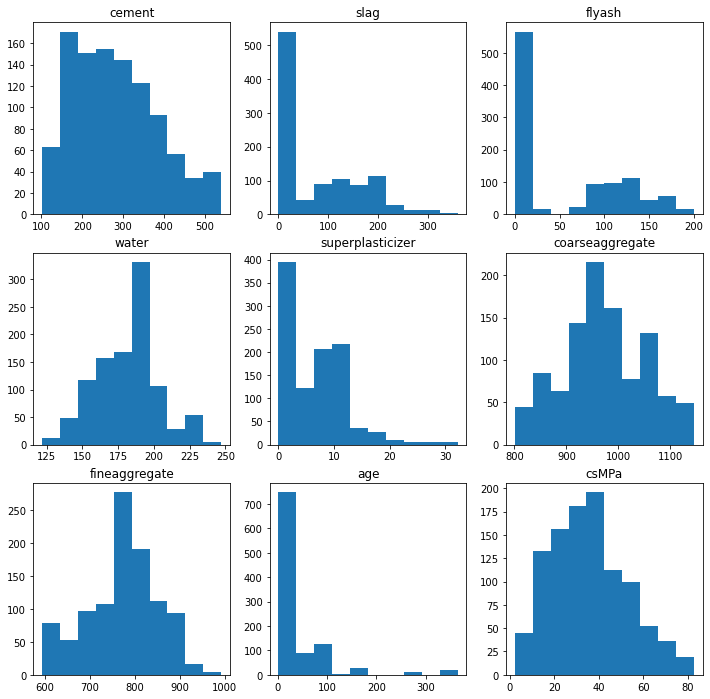

In [27]:
fig,axes = plt.subplots(3,3,figsize=(12,12))
for column, ax in zip(data.columns,axes.flatten()):
    ax.hist(data[column])
    ax.set_title(column)

## Regresja liniowa

- Jawne współczynniki kierunkowe dla poszczególnych zmiennych oraz wyraz wolny (intercept)
- Minimalizacja funkcji kosztu - naczęściej RMSE
- współczynniki kierunkowe dobierane tak aby zminimalizować ogólny błąd a nie błędy dla poszczególnych zmiennych
- Przeuczenie wynika z dopasowania dużej ilości zmiennych o małym potencjale wyjaśniania

In [33]:
# model_o - ordinary least squares
from sklearn.linear_model import LinearRegression as ls
X = data.iloc[:,:-1]
y = data.iloc[:,-1]
model_o = ls().fit(X,y)
yhat = model_o.predict(X)
mape_o = mean_absolute_percentage_error(y,yhat)
print(mape_o)


0.3130633274756218


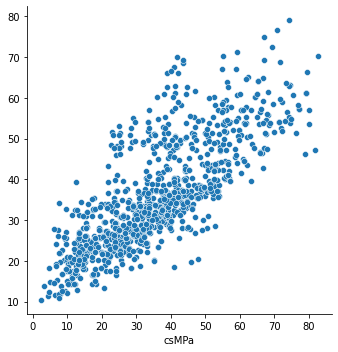

In [34]:
sns.relplot(x=y,y=yhat)

W powyższym przykładzie:
- Zmienne nie są skalowane - czy jest to znaczący błąd
- Zmienne nie mają rozkładu normalnego - ugoólniony model liniowy *gls*
- Występują nieliniowe zależności - uogólniony model addytywny *GAM* lub drzewa decyzyjne

**Dlaczego nie używamy RMSE?** ? RMSE jest proporcjonalny do wartości zmiennych, po skalowaniu znacząco spadnie. Błęd procentowy jest niezależny od wartości zmiennych

In [35]:
# skalowanie zmiennych
scaler = StandardScaler().fit(data)
scaled = scaler.transform(data)
X = scaled[:,:-1]
y = scaled[:,-1]
model_s = ls().fit(X,y)
yhat = model_s.predict(X)
mape_s = mean_absolute_percentage_error(y,yhat)
print(mape_s)

1.9426573834620586


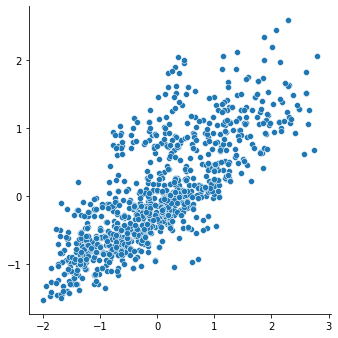

In [36]:
sns.relplot(x=y,y=yhat)

Python (sklearn) w przeciwieństwie do R nie posiada implementacji *Generalised Least Squares - gls*. Możemy symulować gls poprzez zastosowanie transformacji potęgowej (*Yeo-Johnson*) lub kwantylowej (do rozkładu jednorodnego) dla każdej ze zmiennych. Błąd spada, nieco bardzej w przypadku transformacji kwantylowej.  

In [37]:
# transformacja potęgowa
transformer_p = PowerTransformer().fit(data)
transformed = transformer_p.transform(data)
X = transformed[:,:-1]
y = transformed[:,-1]
model_p = ls().fit(X,y)
yhat = model_p.predict(X)
mape_p = mean_absolute_percentage_error(y,yhat)
print(mape_p)

1.3661919306454589


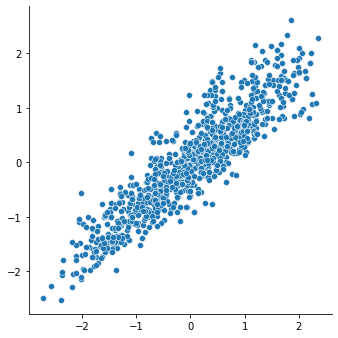

In [38]:
sns.relplot(x=y,y=yhat)

Jak zmieniają się wartości współczynnika *lambda* dla transformacji Yeo-Johnson? 

Lambda = 1 oznacza brak transformacji, czyli rozkład zbliżony do normalnego, odchylenia od 1 wskazują na lewo- lub prawo- skośność.

https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-transformer

In [40]:
list(zip(data.columns,transformer_p.lambdas_))

[('cement', 0.1695440896649902),
 ('slag', 0.016633049794017984),
 ('flyash', -0.1364796243320599),
 ('water', 0.8084380615141394),
 ('superplasticizer', 0.26416021234112386),
 ('coarseaggregate', 1.1293949218650816),
 ('fineaggregate', 1.830763450246997),
 ('age', 0.001771319243509301),
 ('csMPa', 0.5655069345843299)]

In [51]:
transformer_q = QuantileTransformer().fit(data)
transformed = transformer_q.transform(data)
X = transformed[:,:-1]
y = transformed[:,-1]
model_q = ls().fit(X,y)
yhat = model_q.predict(X)
mae_q = mean_absolute_error(y,yhat)
print(mae_q)

0.10216735425317956


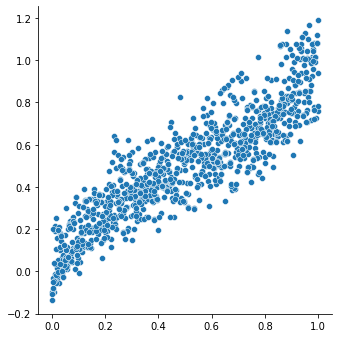

In [43]:
sns.relplot(x=y,y=yhat)

Porównajmy, jak zmieniają się współczynniki kierunkowe poszczególnych zmiennych po zastosowaniu transformacji:

In [48]:
coefs = pd.DataFrame((model_o.coef_,model_s.coef_,model_p.coef_,model_q.coef_),columns=data.columns[:-1])
coefs = coefs.T
coefs.columns=["Ord","scaled","GLS-YJ", "GLS-Q"]
coefs

,Ord,scaled,GLS-YJ,GLS-Q
cement,0.119804,0.749462,0.547116,0.549076
slag,0.103866,0.536431,0.315618,0.237473
flyash,0.087934,0.336862,0.091021,0.082950
water,-0.149918,-0.191634,-0.290424,-0.267267
superplasticizer,0.292225,0.104497,0.114694,0.060116
coarseaggregate,0.018086,0.084179,-0.019668,-0.018217
fineaggregate,0.020190,0.096900,-0.089240,-0.070407
age,0.114222,0.431911,0.619299,0.642512


Transformacje powodują że zmieniają się współczynniki poszczególnych zmiennych:
- skalowanie i transformacje obniżają wartość *superplasticizer*
- transdormacje podnoszą wartość wskaźnika *cement*
- transformacje zmieniają role agregatów
- transformacje zmieniają rolę wieku

## Czy zmienne wskaźnikach zbliżonych do 1 są rzeczywiście najistotniejsze


In [53]:

inc_error = []
for v in data.columns[:-1]:
    Xdash = data.drop(columns=v)
    transformed = QuantileTransformer().fit_transform(Xdash)
    X = transformed[:,:-1]
    y = transformed[:,-1]
    model = ls().fit(X,y)
    yhat = model.predict(X)
    inc_error.append(np.sqrt(mean_absolute_error(y,yhat))-mae_q)
list(zip(inc_error,model_q.coef_))    
    

[(0.24883018336032076, 0.5490755059118754),
 (0.2278097242888174, 0.23747279078498407),
 (0.21933530305360066, 0.08294953726740688),
 (0.22420188883608044, -0.2672670047913763),
 (0.21800503793827547, 0.06011568923667099),
 (0.21751497405227016, -0.01821705028896601),
 (0.21768218314654253, -0.07040744930586265),
 (0.3231520970103995, 0.6425121470600543)]

## Znaczenie zmiennych w przypadku bardzo dużej liczby zmiennych (dane hiperspectralne)

dane toxic: zmodyfikowane dane pomiarów spekralnych toksycznych grzybów z rodzaju Cordiceps

In [57]:
data = pd.read_csv("Datasets/toxic.csv")
X = data.iloc[:,:-1]
y = data.iloc[:,-1]
X.columns

Index(['Unnamed: 0', '350', '360', '370', '380', '390', '400', '410', '420',
       '430',
       ...
       '1250', '1260', '1270', '1280', '1290', '1300', '1310', '1320', '1330',
       '1340'],
      dtype='object', length=101)

Do tego typu danych, gdzie spodziewamy się, że jedynie niektóre zmienne są istotne używamy modeli penalizowanych (np. ElasticNet).

ElasticNet stosuje balans pomiędzy zastosowaniem normy L1 (Ridge - eliminacji zmiennych o niskich) a L2 (Lasso - osłabianie roli zmiennych o niskich współczynnikach)

In [71]:
from sklearn.linear_model import ElasticNet as lsEN
model = lsEN(alpha=0.2,l1_ratio=0.9,fit_intercept=True).fit(X,y)
yhat = model.predict(X)
selector = (model.coef_>0)
list(zip(X.columns[selector],model.coef_[selector]))

[('350', 14.570162587851149),
 ('490', 1.0729993996829754),
 ('580', 1.5592970434169264),
 ('610', 10.694582893544712),
 ('640', 7.681201136208559),
 ('650', 2.5189963463301788),
 ('690', 7.9903680003759145),
 ('700', 12.660724509245314),
 ('800', 2.207480181285522),
 ('1000', 19.194707354102125),
 ('1050', 6.919785078666655),
 ('1130', 6.637354699796833),
 ('1280', 3.655655823512071)]

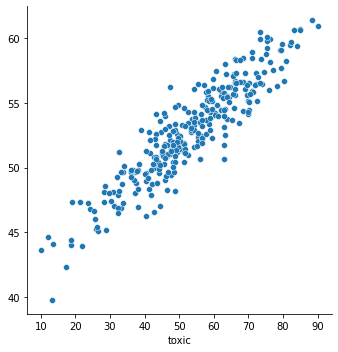

In [67]:
sns.relplot(x=y,y=yhat)